## Benchmark for measuring performance of engineered features and models
Add features created from previous and next records in original order

In [1]:
import os
if os.name=='nt':
    try:
        mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
        os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
    except:
        pass

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sys import getsizeof
import time
import gc

from scipy import fftpack

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/c3se/NOBACKUP/users/lyaa/conda_dir/miniconda/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
import pickle

def save_pickle(x, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_pickle(filename):
    with open(filename, 'rb') as handle:
        x = pickle.load(handle)
    return x

In [3]:
from numba import jit

@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

@jit
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    new_mcc = 0
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc
    
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    return 'MCC', best_mcc

In [4]:
def cross_val_predict_rskf(clf, x_train, y_train, n_splits=3, 
                           n_repeats=2, random_state=42, verbose=False, early_stopping=10):
    '''
    Repeated stratified KFold CV, returns predictions for 
    each repeat and average score.
    n_repeats: repetitions of CV
    to disable erlay stopping, set early_stopping to None
    '''
    scores = []
    n_trees = []
    clfs = []
    running_time = []
    
    rskf = RepeatedStratifiedKFold(n_repeats=n_repeats, n_splits=n_splits, 
                                   random_state=0)
    np.random.seed(random_state)
    for n, (train_index, test_index) in enumerate(rskf.split(x_train, y_train)):
        print('Round {}'.format(n))
        start_time = time.time()
        x_train_tmp, x_test_tmp = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_tmp, y_test_tmp = y_train.iloc[train_index], y_train.iloc[test_index]

        clf.random_state = np.random.randint(10000000)
        
        if early_stopping is not None:
            clf.fit(x_train_tmp, y_train_tmp, 
                    eval_set=[(x_test_tmp, y_test_tmp)], 
                    eval_metric=mcc_eval, early_stopping_rounds=early_stopping,
                    verbose=verbose)
            scores.append(-clf.best_score)
            n_trees.append(clf.best_ntree_limit)
        else:
            clf.fit(x_train_tmp, y_train_tmp)
            scores.append(eval_mcc(y_test_tmp.values, clf.predict_proba(x_test_tmp)[:, 1]))
            n_trees.append(clf.n_estimators)
        
        clfs.append(clf)
        running_time.append(time.time()-start_time)
        print('Split {}, score = {:.3f}, best_ntree_limit = {}, total time = {:.3f} min'.format(n, scores[n], 
            n_trees[n], sum(running_time)/60))

    print('Score mean = {:.3f}, std = {:.3f}'.format(np.mean(scores), np.std(scores)))
    
    return clfs, scores, n_trees, running_time

In [5]:
def cross_val_predict_skf_rm(clf, x_train, y_train, n_splits=3, 
                           n_repeats=2, random_state=42, verbose=False, early_stopping=10):
    '''
    Stratified KFold CV with repeated models
    to disable erlay stopping, set early_stopping to None
    '''
    scores = []
    n_trees = []
    clfs = []
    running_time = []

    skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)
    np.random.seed(random_state)

    for m in range(n_repeats):
        print('Repeat {}'.format(m))
        for n, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
            start_time = time.time()
            x_train_tmp, x_test_tmp = x_train.iloc[train_index], x_train.iloc[test_index]
            y_train_tmp, y_test_tmp = y_train.iloc[train_index], y_train.iloc[test_index]

            clf.random_state = np.random.randint(10000000)
            # print(clf.random_state)

            if early_stopping is not None:
                clf.fit(x_train_tmp, y_train_tmp, 
                        eval_set=[(x_test_tmp, y_test_tmp)], 
                        eval_metric=mcc_eval, early_stopping_rounds=early_stopping,
                        verbose=verbose)
                scores.append(-clf.best_score)
                n_trees.append(clf.best_ntree_limit)
            else:
                clf.fit(x_train_tmp, y_train_tmp)
                scores.append(eval_mcc(y_test_tmp.values, clf.predict_proba(x_test_tmp)[:, 1]))
                n_trees.append(clf.n_estimators)
            
            clfs.append(clf)
            running_time.append(time.time() - start_time)
            print('Split {}, score = {:.3f}, n_best_trees = {}, total time = {:.3f} min'.format(n, 
                scores[m*n_repeats+n], n_trees[m*n_repeats+n], sum(running_time)/60))

    print('Score mean = {:.3f}, std = {:.3f}'.format(np.mean(scores), np.std(scores)))
    
    return clfs, scores, n_trees, running_time

In [6]:
def cross_val_predict_skf_rm_xgb(params, x_train, y_train, num_boost_round=3, n_splits=3, 
                           n_repeats=2, random_state=3795264, verbose_eval=False):
    '''
    Stratified KFold CV with repeated models
    Early stopping is totally disabled
    Uses xgb.cv API
    verbose_eval is the same as in xgb.train
    '''
    cv_results = {}
    clfs = {}
    running_time = {}
    
    np.random.seed(random_state)
    skf = StratifiedKFold(n_splits=n_splits, random_state=np.random.randint(10**6), shuffle=True)
    
    for m in range(n_repeats):
        for n, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
            
            start_time = time.time()
            
            # Construct DMatrix
            dtrain = xgb.DMatrix(x_train.iloc[train_index], label=y_train.iloc[train_index])
            dtest = xgb.DMatrix(x_train.iloc[test_index], label=y_train.iloc[test_index])
            
            # Placeholder for evals_result
            cv_results[m, n] = {}
            params['seed'] = np.random.randint(10**6)
            clfs[m, n] = xgb.train(params, dtrain, num_boost_round=num_boost_round,
                                   evals=[(dtrain, 'train'), (dtest, 'test')],
                                  feval=mcc_eval, maximize=True, early_stopping_rounds=None, 
                                  evals_result=cv_results[m, n], verbose_eval=verbose_eval)
        
            running_time[m, n] = time.time() - start_time
            
            print('Repeat {}, split {}, test MCC = {:.3f}, running time = {:.3f} min'.format(m, n, 
                cv_results[m, n]['test']['MCC'][-1], running_time[m, n]/60))
        
    # Post-process cv_results
    cv_results_final = {}
    for m in range(n_repeats):
        for n in range(n_splits):
            cv_results_final['train', m, n] = cv_results[m, n]['train']['MCC']
            cv_results_final['test', m, n] = cv_results[m, n]['test']['MCC']
    
    df = pd.DataFrame.from_dict(cv_results_final)
    df.index.name = 'iteration'
    df.columns.names = ['dataset', 'repeat', 'split']

    print('Score mean = {:.3f}, std = {:.3f}'.format(df['test'].iloc[-1].mean(), df['test'].iloc[-1].std()))
    
    return df, clfs, running_time

In [7]:
def time_difference_to_failures(x, failure_max):
    '''
    Find the average time difference to the last and next failure_max failures.
    x should have ['Response', 'time_start', 'time_end']
    '''
    
    u = x[['Response', 'time_start']].copy()
    u.columns = ['Response', 'time']
    x_start = time_difference_to_failures_helper(u, failure_max, '_start')
    
    u = x[['Response', 'time_end']].copy()
    u.columns = ['Response', 'time']
    x_end = time_difference_to_failures_helper(u, failure_max, '_end')
    
    return x_start.join(x_end)

def time_difference_to_failures_helper(x, failure_max, suffix):
    '''
    Find the mean time difference since last/next 1, 2, ..., failure_max failures
    when samples are sorted by the time column
    suffix is used for column names of the final results
    x is a DataFrame containing:
    - Both train and test data
    - Two columns: Response and a time column, 
        which is used to sort samples and calculate time differences
    '''
    
    # sort by time and Id
    x.sort_values(['time', 'Id'], inplace=True)
    x.Response.fillna(0, inplace=True)
    x.Response = x.Response.astype(np.int8)
    
    # ranking in sorted order
    x['rank_sort_time'] = np.arange(1, len(x)+1)
    
    # rank of failures
    x['rank_failure'] = x['Response']
    x['rank_failure'] = x['rank_failure'].cumsum()
    x.loc[x['Response']!=1, 'rank_failure'] = 0
    
    # the rank_failure of the 1st previous failure for each sample
    # for the first several samples without previous failures, use 0
    x['fp1'] = x['rank_failure'].shift().fillna(0).astype(np.int64)
    x['fp1'] = x['fp1'].cummax()
    x['fp1'] = x['fp1'].astype(np.int64)
    
    # the failure rank of the 2nd to failure_max previous failure for each sample
    failure_list = np.arange(2, failure_max+1)
    for f in failure_list:
        x['fp'+str(f)] = x['fp'+str(f-1)]-1
        x.loc[x['fp'+str(f)]<0, 'fp'+str(f)] = 0
        x['fp'+str(f)] = x['fp'+str(f)].astype(np.int64)
        
    # the failure rank of the 1st next failure for each sample
    # for the last several samples do not have next failure, use failure_count+1
    failure_count = sum(x['Response'])
    x['fn1'] = x['fp1'].shift(-1).fillna(failure_count)+1
    # the total number of failures
    # assign np.nan to rows whose rank_failure is larger than failure_count
    x.loc[x['fn1']>failure_count, 'fn1'] = failure_count+1
    x['fn1'] = x['fn1'].astype(np.int64)

    # the failure rank of the 2nd to failure_max (failure_max=10 here) next failure for each sample
    for f in failure_list:
        x['fn'+str(f)] = x['fn'+str(f-1)]+1
        x.loc[x['fn'+str(f)]>failure_count, 'fn'+str(f)] = failure_count+1
        x['fn'+str(f)] = x['fn'+str(f)].astype(np.int64)
        
    # a mapping from failure rank to start time of the failure
    rank_failure_to_time = x.loc[x['rank_failure']!=0, ['rank_failure', 'time']].set_index(
        'rank_failure', drop=True, inplace=False)
    rank_failure_to_time = rank_failure_to_time.to_dict()
    rank_failure_to_time = rank_failure_to_time['time']
    rank_failure_to_time[0] = np.nan
    rank_failure_to_time[failure_count+1] = np.nan
    
    # map from failure rank to time of the failure 
    for f in range(1, failure_max+1):
        x['fp{}_time'.format(f)] = x['fp'+str(f)].map(rank_failure_to_time)
        
    # map from failure rank to time of the failure 
    for f in range(1, failure_max+1):
        x['fn{}_time'.format(f)] = x['fn'+str(f)].map(rank_failure_to_time)
        
    # Calculate average of the next n failures
    ave_list = []
    for f in range(1, failure_max+1):
        ave_list.append('fn{}_time'.format(f))
        x['fn{}_time_ave{}'.format(f, suffix)] = x[ave_list].mean(axis=1) - x['time']

    # Calculate average of the previous n failures
    ave_list = []
    for f in range(1, failure_max+1):
        ave_list.append('fp{}_time'.format(f))
        x['fp{}_time_ave{}'.format(f, suffix)] = x[ave_list].mean(axis=1) - x['time']
        
    # drop auxiliary columns
    drop_list = [k for i in range(1, failure_max+1) for k in ['fp'+str(i), 'fn'+str(i)]]
    drop_list.extend([k for f in range(1, failure_max+1) for k in ['fp'+str(f)+'_time', 'fn'+str(f)+'_time']])
    drop_list.extend(['time', 'rank_sort_time', 'rank_failure', 'Response'])
    x.drop(drop_list, axis=1, inplace=True)
    
    # sort index
    x.sort_index(by='Id', axis=0, inplace=True)    
    
    return x

In [8]:
def rank_time(time_features, by):
    # Create time slot identifier for start time
    u = time_features.groupby(by)[by].count()
    u.name = 'count_'+by
    u = pd.DataFrame(u)
    u.reset_index(drop=False, inplace=True)
    u.reset_index(drop=False, inplace=True)
    u.drop(['count_'+by], axis=1, inplace=True)
    u.columns = ['rank_'+by, by]
    u.set_index(by, drop=True, inplace=True)
    time_features = time_features.join(u, on=by)
    
    return time_features

In [9]:
def count_recent(x, suffix, time_windows=['60min', '150min', '1440min', '10080min']):
    '''
    Count number of recent records within the given time windows both in forward and backward directions
    '''
    x = x.sort_values(by='time')
    x.time = x.time/0.1
    x = x.fillna(x.max()+2000)
    x.time = pd.to_timedelta(x.time, unit='h')
    x['dummy'] = 1

    # Time windows 
    #     time_windows = ['60min', '150min', '1440min', '10080min']
    # Group by start time
    u = pd.DataFrame(x.groupby('time')['time'].count())
    u.columns = ['counts']
    u.reset_index(drop=False, inplace=True)

    # identifier to each time slot
    u['rank_time'] = np.arange(len(u))
    
    # Backward looking time windows
    for t in time_windows:
        u['counts_last_{}{}'.format(t, suffix)] = u.rolling(t, on='time')['counts'].sum()

    # Construct forward looking time window
    u['time_negative'] = -u['time']
    u.sort_values('time_negative', inplace=True)
    for t in time_windows:
        u['counts_next_{}{}'.format(t, suffix)] = u.rolling(t, on='time_negative')['counts'].sum()
    u.sort_values(by='time', inplace=True)

    # Drop auxiliary columns 
    u.drop(['time_negative', 'counts', 'time'], axis=1, inplace=True)
    u.set_index('rank_time', inplace=True, drop=True)
    
    return u

### Time Series Featrues

First do Fourier transform or autocorrelation on the time series, find the period in time. Then create the following features:
- StartStationTimes
    * Start time on each station
- StartTime, EndTime, Duration
    * Overall start and end time and duration of production
- StationTimeDiff
    * The time interval between two neighboring stations?
- Start/End part of week (mod 1680)
    * Fourier transform
    * Autocorrelation
- Number of records in next/last 2.5h, 24h, 168h for each station
    * First convert numeric to `deltatime` by `x['time_start'] = pd.to_deltatime(x['time_start'], unit='h')`
    * `df.rolling(window='60min', on='time_start')['counts'].sum()`
- Number of records in the same time (6 mins)
- MeanTimeDiff since last 1/5/10 failure(s)
- MeanTimeDiff till next 1/5/10 failure(s)

### Load train and test data

In [10]:
# important numeric features are imported
important_features = pd.read_csv('../benchmark_1/important_numeric_features.csv', index_col=0, header=None)
important_features = list(important_features.values.ravel())
important_features.extend(['Id', 'Response'])

In [11]:
x_train_numeric = pd.read_csv('../../data/train_numeric.csv.zip', index_col=0, usecols=important_features, dtype=np.float32)

y_train = x_train_numeric.Response
x_train_numeric.drop(['Response'], axis=1, inplace=True)

In [12]:
date_train = pd.read_csv('../benchmark_2/train_station_flow.csv.gz', index_col=0, header=None)

In [13]:
x_train = x_train_numeric.join(date_train)

columns = list(x_train.columns)
columns[-1] = 'station_flow'
x_train.columns = columns

In [14]:
x_test_numeric = pd.read_csv('../../data/test_numeric.csv.zip', index_col=0, usecols=important_features[:-1], dtype=np.float32)

date_test = pd.read_csv('../benchmark_2/test_station_flow.csv.gz', index_col=0, header=None)

x_test = x_test_numeric.join(date_test)
x_test.columns = columns

In [15]:
x_train.index = x_train.index.astype(np.int64)
x_test.index = x_test.index.astype(np.int64)

In [16]:
del x_train_numeric, x_test_numeric
gc.collect()

49

### Load benchmark_3 features

In [17]:
start_chunk = pd.read_csv('../benchmark_3/start_chunk.csv.gz', index_col=0)

start_chunk_train = start_chunk.loc[start_chunk.Response!=-1].drop(['Response'], axis=1)
start_chunk_test = start_chunk.loc[start_chunk.Response==-1].drop(['Response'], axis=1)

In [18]:
x_train = x_train.join(start_chunk_train, on='Id')
x_test = x_test.join(start_chunk_test, on='Id')

gc.collect()

35

### Load benchmark_4 features

In [19]:
n = pd.read_csv('../benchmark_4/benchmark_4_neighbors.csv.gz', index_col=0)

neighbor_train = n.loc[n.Response!=-1]
neighbor_train.drop(['Response'], axis=1, inplace=True)

neighbor_test = n.loc[n.Response==-1]
neighbor_test.drop(['Response'], axis=1, inplace=True)

print(neighbor_test.shape, neighbor_train.shape)

x_train = x_train.join(neighbor_train, on='Id')
x_test = x_test.join(neighbor_test, on='Id')

gc.collect()

(1183748, 14) (1183747, 14)


28

### Add neighbor numeric features
The important numeric features selected from previous and next records

In [20]:
# Date + station flow data will be added to x
x = pd.concat([x_train, x_test], keys=['train', 'test'])
x.sort_index(axis=0, level='Id', inplace=True)

# Add the neighbor records
x = x.join(x.iloc[:, :150].shift(), rsuffix='_previous')
x = x.join(x.iloc[:, :150].shift(-1), rsuffix='_next')

In [21]:
x_train = x.loc['train']
x_test = x.loc['test']

In [22]:
del x
gc.collect()

63

### Load benchmark_7 features

Time series features

In [23]:
time_features = pd.read_hdf('time_features_diff.hdf', 'time_features')
time_features.drop(['time_start', 'time_end', 'time_duration', 'Response'], axis=1, inplace=True)

In [24]:
mean_diff_cols = time_features.iloc[:, -40:].columns.tolist()

In [25]:
# Do not use MeanTimeDiff features
x_train = x_train.join(time_features.loc['train'].iloc[:, :-40])
x_test = x_test.join(time_features.loc['test'].iloc[:, :-40])

In [26]:
print(x_train.shape, x_test.shape)

(1183747, 754) (1183748, 754)


In [27]:
del time_features
gc.collect()

100

In [28]:
# x_train.drop(['Response'], axis=1, inplace=True)
# x_test.drop(['Response'], axis=1, inplace=True)

### CV score based on stratified KFold with repeated models

In [32]:
# CV
# specify parameters 
# 'booster':'gbtree'
params = {'max_depth':14, 'eta':0.03, 'silent':1, 'objective':'binary:logistic', 'nthread':20,
         'lambda':4, 'subsample':0.9, 'min_child_weight':5, 'booster':'gbtree', 'alpha':0,
         'base_score':0.0058, 'colsample_bytree':0.6}

# 'booster':'dart'
# params = {'max_depth':14, 'eta':0.03, 'silent':1, 'objective':'binary:logistic', 'nthread':20,
#         'lambda':4, 'subsample':0.9, 'min_child_weight':5, 'booster':'dart', 'alpha':0,
#         'base_score':0.0058, 'nthread':20, 'colsample_bytree':0.6, 
#         'sample_type':'uniform', 'normalize_type':'tree', 'rate_drop':0.1, 'skip_drop':0.2, 'one_drop':True}

cv_results, clfs, running_time = cross_val_predict_skf_rm_xgb(params, x_train, y_train, 
                                                              num_boost_round=80, n_splits=5, 
                                                              n_repeats=3, random_state=59475038, 
                                                              verbose_eval=True)

results = {'clfs': clfs, 'cv_results': cv_results, 'running_time': running_time}
save_pickle(results, 'results_benchmark_7_time_features_cv_1.pickle')

[0]	train-error:0.005811	test-error:0.005812	train-MCC:0.309577	test-MCC:0.292737
[1]	train-error:0.005811	test-error:0.005812	train-MCC:0.362228	test-MCC:0.345426
[2]	train-error:0.005811	test-error:0.005812	train-MCC:0.379266	test-MCC:0.361111
[3]	train-error:0.005811	test-error:0.005812	train-MCC:0.383161	test-MCC:0.365065
[4]	train-error:0.005811	test-error:0.005812	train-MCC:0.388288	test-MCC:0.370085
[5]	train-error:0.005811	test-error:0.005812	train-MCC:0.388325	test-MCC:0.370975
[6]	train-error:0.005811	test-error:0.005812	train-MCC:0.393586	test-MCC:0.373129
[7]	train-error:0.005811	test-error:0.005812	train-MCC:0.404252	test-MCC:0.374383
[8]	train-error:0.005811	test-error:0.005812	train-MCC:0.409218	test-MCC:0.372544
[9]	train-error:0.005811	test-error:0.005812	train-MCC:0.414327	test-MCC:0.379948
[10]	train-error:0.005811	test-error:0.005812	train-MCC:0.420715	test-MCC:0.389847
[11]	train-error:0.005811	test-error:0.005812	train-MCC:0.429048	test-MCC:0.393903
[12]	train-err

[19]	train-error:0.005744	test-error:0.005711	train-MCC:0.474596	test-MCC:0.427916
[20]	train-error:0.005714	test-error:0.005664	train-MCC:0.47646	test-MCC:0.426685
[21]	train-error:0.005653	test-error:0.005622	train-MCC:0.481429	test-MCC:0.426947
[22]	train-error:0.005607	test-error:0.005554	train-MCC:0.484751	test-MCC:0.429192
[23]	train-error:0.005526	test-error:0.005461	train-MCC:0.486515	test-MCC:0.431602
[24]	train-error:0.00544	test-error:0.005369	train-MCC:0.486111	test-MCC:0.432033
[25]	train-error:0.005339	test-error:0.00528	train-MCC:0.487613	test-MCC:0.432557
[26]	train-error:0.005284	test-error:0.005242	train-MCC:0.491639	test-MCC:0.434505
[27]	train-error:0.00525	test-error:0.005212	train-MCC:0.492922	test-MCC:0.435682
[28]	train-error:0.005234	test-error:0.005204	train-MCC:0.493685	test-MCC:0.43756
[29]	train-error:0.005226	test-error:0.005187	train-MCC:0.495329	test-MCC:0.436998
[30]	train-error:0.005215	test-error:0.00517	train-MCC:0.498483	test-MCC:0.437835
[31]	train

[38]	train-error:0.004928	test-error:0.005119	train-MCC:0.502944	test-MCC:0.45203
[39]	train-error:0.00491	test-error:0.005102	train-MCC:0.503877	test-MCC:0.450118
[40]	train-error:0.004895	test-error:0.005077	train-MCC:0.507887	test-MCC:0.450389
[41]	train-error:0.004887	test-error:0.005073	train-MCC:0.509876	test-MCC:0.452729
[42]	train-error:0.004874	test-error:0.00506	train-MCC:0.510669	test-MCC:0.451695
[43]	train-error:0.004866	test-error:0.005043	train-MCC:0.512477	test-MCC:0.450118
[44]	train-error:0.004843	test-error:0.005031	train-MCC:0.514527	test-MCC:0.451649
[45]	train-error:0.004829	test-error:0.005031	train-MCC:0.515452	test-MCC:0.449541
[46]	train-error:0.004813	test-error:0.005018	train-MCC:0.517475	test-MCC:0.451754
[47]	train-error:0.004796	test-error:0.005014	train-MCC:0.519079	test-MCC:0.452573
[48]	train-error:0.004773	test-error:0.00501	train-MCC:0.520408	test-MCC:0.451818
[49]	train-error:0.004763	test-error:0.004984	train-MCC:0.520547	test-MCC:0.453613
[50]	tra

[57]	train-error:0.004659	test-error:0.004836	train-MCC:0.542592	test-MCC:0.44571
[58]	train-error:0.004654	test-error:0.004811	train-MCC:0.544455	test-MCC:0.446324
[59]	train-error:0.004645	test-error:0.004807	train-MCC:0.547184	test-MCC:0.447654
[60]	train-error:0.004633	test-error:0.004803	train-MCC:0.550561	test-MCC:0.448984
[61]	train-error:0.004624	test-error:0.004803	train-MCC:0.551752	test-MCC:0.44789
[62]	train-error:0.004617	test-error:0.00479	train-MCC:0.552659	test-MCC:0.447346
[63]	train-error:0.004615	test-error:0.004781	train-MCC:0.555084	test-MCC:0.44789
[64]	train-error:0.004611	test-error:0.004786	train-MCC:0.556162	test-MCC:0.448606
[65]	train-error:0.004605	test-error:0.00479	train-MCC:0.558263	test-MCC:0.449534
[66]	train-error:0.004592	test-error:0.00479	train-MCC:0.559989	test-MCC:0.448804
[67]	train-error:0.004587	test-error:0.004786	train-MCC:0.562332	test-MCC:0.449335
[68]	train-error:0.004582	test-error:0.004781	train-MCC:0.564016	test-MCC:0.450643
[69]	train

[76]	train-error:0.004539	test-error:0.004676	train-MCC:0.579736	test-MCC:0.462154
[77]	train-error:0.00453	test-error:0.004676	train-MCC:0.581123	test-MCC:0.461417
[78]	train-error:0.004526	test-error:0.004672	train-MCC:0.582244	test-MCC:0.461706
[79]	train-error:0.004523	test-error:0.004676	train-MCC:0.58511	test-MCC:0.461431
Repeat 0, split 4, test MCC = 0.461, running time = 6.506 min
[0]	train-error:0.005811	test-error:0.005812	train-MCC:0.250307	test-MCC:0.237804
[1]	train-error:0.005811	test-error:0.005812	train-MCC:0.294077	test-MCC:0.28398
[2]	train-error:0.005811	test-error:0.005812	train-MCC:0.31684	test-MCC:0.293713
[3]	train-error:0.005811	test-error:0.005812	train-MCC:0.354783	test-MCC:0.335184
[4]	train-error:0.005811	test-error:0.005812	train-MCC:0.369799	test-MCC:0.340636
[5]	train-error:0.005811	test-error:0.005812	train-MCC:0.384404	test-MCC:0.355881
[6]	train-error:0.005811	test-error:0.005812	train-MCC:0.404719	test-MCC:0.377079
[7]	train-error:0.005811	test-error:

[15]	train-error:0.005811	test-error:0.005812	train-MCC:0.457514	test-MCC:0.425804
[16]	train-error:0.005811	test-error:0.005812	train-MCC:0.461651	test-MCC:0.426558
[17]	train-error:0.005811	test-error:0.005812	train-MCC:0.46363	test-MCC:0.430386
[18]	train-error:0.00581	test-error:0.005808	train-MCC:0.4662	test-MCC:0.427916
[19]	train-error:0.005809	test-error:0.005808	train-MCC:0.468251	test-MCC:0.430342
[20]	train-error:0.005787	test-error:0.00577	train-MCC:0.470509	test-MCC:0.430386
[21]	train-error:0.005734	test-error:0.005736	train-MCC:0.473626	test-MCC:0.432935
[22]	train-error:0.005682	test-error:0.005698	train-MCC:0.476459	test-MCC:0.433265
[23]	train-error:0.005634	test-error:0.005652	train-MCC:0.47895	test-MCC:0.435356
[24]	train-error:0.00557	test-error:0.005571	train-MCC:0.481478	test-MCC:0.436482
[25]	train-error:0.005502	test-error:0.005512	train-MCC:0.484879	test-MCC:0.438384
[26]	train-error:0.005465	test-error:0.005449	train-MCC:0.487126	test-MCC:0.437926
[27]	train-

[34]	train-error:0.005021	test-error:0.005212	train-MCC:0.501908	test-MCC:0.446601
[35]	train-error:0.004995	test-error:0.005204	train-MCC:0.503964	test-MCC:0.446388
[36]	train-error:0.004968	test-error:0.005212	train-MCC:0.50527	test-MCC:0.4463
[37]	train-error:0.004956	test-error:0.005204	train-MCC:0.505936	test-MCC:0.446719
[38]	train-error:0.004935	test-error:0.005195	train-MCC:0.506881	test-MCC:0.445437
[39]	train-error:0.00492	test-error:0.005178	train-MCC:0.507398	test-MCC:0.446696
[40]	train-error:0.004895	test-error:0.005157	train-MCC:0.508008	test-MCC:0.448027
[41]	train-error:0.004876	test-error:0.005132	train-MCC:0.508503	test-MCC:0.449803
[42]	train-error:0.004864	test-error:0.005115	train-MCC:0.510387	test-MCC:0.450055
[43]	train-error:0.004836	test-error:0.005107	train-MCC:0.5113	test-MCC:0.450082
[44]	train-error:0.004817	test-error:0.005102	train-MCC:0.511793	test-MCC:0.452392
[45]	train-error:0.004803	test-error:0.00509	train-MCC:0.512745	test-MCC:0.450023
[46]	train-

[53]	train-error:0.004715	test-error:0.004841	train-MCC:0.513555	test-MCC:0.452486
[54]	train-error:0.004705	test-error:0.004824	train-MCC:0.51408	test-MCC:0.453197
[55]	train-error:0.004699	test-error:0.004803	train-MCC:0.514385	test-MCC:0.453422
[56]	train-error:0.004682	test-error:0.004803	train-MCC:0.515516	test-MCC:0.45331
[57]	train-error:0.004674	test-error:0.004794	train-MCC:0.515858	test-MCC:0.453976
[58]	train-error:0.004659	test-error:0.004786	train-MCC:0.516354	test-MCC:0.455146
[59]	train-error:0.004654	test-error:0.004781	train-MCC:0.517783	test-MCC:0.456192
[60]	train-error:0.004641	test-error:0.004769	train-MCC:0.518634	test-MCC:0.457177
[61]	train-error:0.004638	test-error:0.004765	train-MCC:0.519747	test-MCC:0.456622
[62]	train-error:0.004629	test-error:0.004773	train-MCC:0.519938	test-MCC:0.457177
[63]	train-error:0.004623	test-error:0.00476	train-MCC:0.520521	test-MCC:0.456674
[64]	train-error:0.004611	test-error:0.004769	train-MCC:0.522728	test-MCC:0.457523
[65]	tr

[72]	train-error:0.004559	test-error:0.004684	train-MCC:0.57823	test-MCC:0.463626
[73]	train-error:0.004555	test-error:0.004689	train-MCC:0.580195	test-MCC:0.463346
[74]	train-error:0.004548	test-error:0.004684	train-MCC:0.581918	test-MCC:0.463455
[75]	train-error:0.004539	test-error:0.00468	train-MCC:0.584262	test-MCC:0.462696
[76]	train-error:0.004534	test-error:0.00468	train-MCC:0.585455	test-MCC:0.463235
[77]	train-error:0.004527	test-error:0.004672	train-MCC:0.590189	test-MCC:0.464235
[78]	train-error:0.004522	test-error:0.004667	train-MCC:0.592519	test-MCC:0.463619
[79]	train-error:0.00452	test-error:0.004667	train-MCC:0.594255	test-MCC:0.463619
Repeat 1, split 4, test MCC = 0.464, running time = 6.507 min
[0]	train-error:0.005811	test-error:0.005812	train-MCC:0.278333	test-MCC:0.274619
[1]	train-error:0.005811	test-error:0.005812	train-MCC:0.330217	test-MCC:0.317568
[2]	train-error:0.005811	test-error:0.005812	train-MCC:0.348861	test-MCC:0.33143
[3]	train-error:0.005811	test-err

[10]	train-error:0.005811	test-error:0.005812	train-MCC:0.425408	test-MCC:0.407805
[11]	train-error:0.005811	test-error:0.005812	train-MCC:0.431113	test-MCC:0.411102
[12]	train-error:0.005811	test-error:0.005812	train-MCC:0.43356	test-MCC:0.412439
[13]	train-error:0.005811	test-error:0.005812	train-MCC:0.441641	test-MCC:0.421958
[14]	train-error:0.005811	test-error:0.005812	train-MCC:0.445895	test-MCC:0.422617
[15]	train-error:0.005811	test-error:0.005808	train-MCC:0.450599	test-MCC:0.425864
[16]	train-error:0.005809	test-error:0.005808	train-MCC:0.453512	test-MCC:0.428693
[17]	train-error:0.005804	test-error:0.005804	train-MCC:0.457973	test-MCC:0.432126
[18]	train-error:0.005792	test-error:0.005778	train-MCC:0.461402	test-MCC:0.436352
[19]	train-error:0.005765	test-error:0.005736	train-MCC:0.46384	test-MCC:0.43503
[20]	train-error:0.005677	test-error:0.005668	train-MCC:0.468418	test-MCC:0.437905
[21]	train-error:0.005625	test-error:0.00563	train-MCC:0.472082	test-MCC:0.440987
[22]	tra

[29]	train-error:0.005204	test-error:0.005326	train-MCC:0.483409	test-MCC:0.430642
[30]	train-error:0.005144	test-error:0.005297	train-MCC:0.485351	test-MCC:0.432775
[31]	train-error:0.005093	test-error:0.005259	train-MCC:0.487808	test-MCC:0.434487
[32]	train-error:0.005061	test-error:0.005225	train-MCC:0.49147	test-MCC:0.434845
[33]	train-error:0.005039	test-error:0.005204	train-MCC:0.495111	test-MCC:0.435706
[34]	train-error:0.005015	test-error:0.00517	train-MCC:0.498143	test-MCC:0.436491
[35]	train-error:0.004988	test-error:0.005153	train-MCC:0.50095	test-MCC:0.436955
[36]	train-error:0.004964	test-error:0.005124	train-MCC:0.501433	test-MCC:0.437809
[37]	train-error:0.00494	test-error:0.005111	train-MCC:0.50231	test-MCC:0.439239
[38]	train-error:0.004923	test-error:0.005098	train-MCC:0.502377	test-MCC:0.440837
[39]	train-error:0.00491	test-error:0.005098	train-MCC:0.504785	test-MCC:0.440612
[40]	train-error:0.004891	test-error:0.005077	train-MCC:0.507025	test-MCC:0.441333
[41]	train

[48]	train-error:0.004765	test-error:0.004917	train-MCC:0.51985	test-MCC:0.447346
[49]	train-error:0.004754	test-error:0.004904	train-MCC:0.520789	test-MCC:0.449107
[50]	train-error:0.004737	test-error:0.004883	train-MCC:0.522276	test-MCC:0.449107
[51]	train-error:0.004716	test-error:0.004866	train-MCC:0.524008	test-MCC:0.448895
[52]	train-error:0.00471	test-error:0.00487	train-MCC:0.525752	test-MCC:0.449537
[53]	train-error:0.004697	test-error:0.004862	train-MCC:0.530173	test-MCC:0.449635
[54]	train-error:0.004688	test-error:0.004866	train-MCC:0.531003	test-MCC:0.44986
[55]	train-error:0.004678	test-error:0.004849	train-MCC:0.534733	test-MCC:0.447967
[56]	train-error:0.004668	test-error:0.004853	train-MCC:0.53616	test-MCC:0.447621
[57]	train-error:0.004661	test-error:0.004841	train-MCC:0.538763	test-MCC:0.44919
[58]	train-error:0.004654	test-error:0.004845	train-MCC:0.540624	test-MCC:0.448853
[59]	train-error:0.004646	test-error:0.004845	train-MCC:0.543185	test-MCC:0.447863
[60]	train

[67]	train-error:0.004571	test-error:0.004705	train-MCC:0.569426	test-MCC:0.466828
[68]	train-error:0.004565	test-error:0.00471	train-MCC:0.571928	test-MCC:0.466103
[69]	train-error:0.004558	test-error:0.004714	train-MCC:0.57349	test-MCC:0.465923
[70]	train-error:0.004553	test-error:0.00471	train-MCC:0.574642	test-MCC:0.465548
[71]	train-error:0.004548	test-error:0.004701	train-MCC:0.576446	test-MCC:0.465548
[72]	train-error:0.004542	test-error:0.004697	train-MCC:0.577586	test-MCC:0.467041
[73]	train-error:0.004541	test-error:0.004697	train-MCC:0.580115	test-MCC:0.467041
[74]	train-error:0.004536	test-error:0.004684	train-MCC:0.581262	test-MCC:0.466279
[75]	train-error:0.004525	test-error:0.004689	train-MCC:0.583027	test-MCC:0.467041
[76]	train-error:0.00452	test-error:0.00468	train-MCC:0.585584	test-MCC:0.467015
[77]	train-error:0.004513	test-error:0.00468	train-MCC:0.586882	test-MCC:0.466444
[78]	train-error:0.004506	test-error:0.004672	train-MCC:0.587869	test-MCC:0.466444
[79]	train

In [33]:
cv_train_mean = cv_results['train'].mean(axis=1)
cv_train_std = cv_results['train'].std(axis=1)
cv_test_mean = cv_results['test'].mean(axis=1)
cv_test_std = cv_results['test'].std(axis=1)

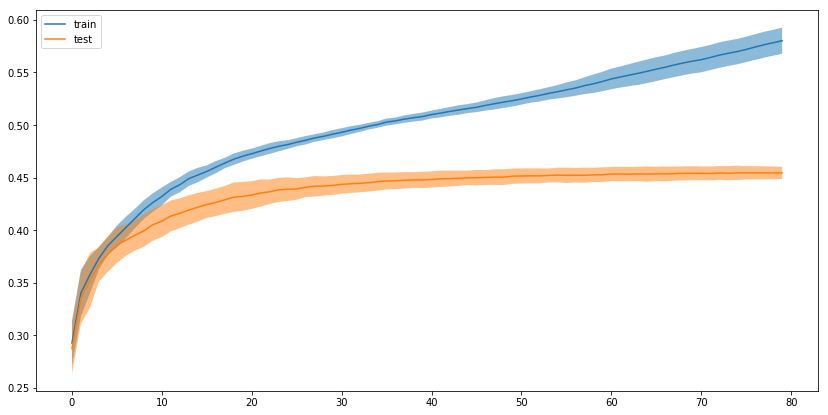

In [34]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(cv_train_mean)), cv_train_mean)
plt.fill_between(np.arange(len(cv_train_mean)), cv_train_mean-cv_train_std, cv_train_mean+cv_train_std, alpha=0.5)
plt.plot(np.arange(len(cv_train_mean)), cv_test_mean)
plt.fill_between(np.arange(len(cv_test_mean)), cv_test_mean-cv_test_std, cv_test_mean+cv_test_std, alpha=0.5)
plt.legend(['train', 'test'])

[0]	train-error:0.005811	train-MCC:0.314437
[1]	train-error:0.005811	train-MCC:0.3386
[2]	train-error:0.005811	train-MCC:0.369991
[3]	train-error:0.005811	train-MCC:0.37682
[4]	train-error:0.005811	train-MCC:0.381712
[5]	train-error:0.005811	train-MCC:0.386315
[6]	train-error:0.005811	train-MCC:0.400422
[7]	train-error:0.005811	train-MCC:0.415169
[8]	train-error:0.005811	train-MCC:0.427719
[9]	train-error:0.005811	train-MCC:0.435261
[10]	train-error:0.005811	train-MCC:0.441734
[11]	train-error:0.005811	train-MCC:0.450533
[12]	train-error:0.005811	train-MCC:0.453993
[13]	train-error:0.005811	train-MCC:0.459678
[14]	train-error:0.005811	train-MCC:0.463946
[15]	train-error:0.005811	train-MCC:0.467919
[16]	train-error:0.005811	train-MCC:0.469607
[17]	train-error:0.005809	train-MCC:0.472873
[18]	train-error:0.005802	train-MCC:0.475189
[19]	train-error:0.005793	train-MCC:0.477328
[20]	train-error:0.005745	train-MCC:0.47795
[21]	train-error:0.00571	train-MCC:0.480433
[22]	train-error:0.005667

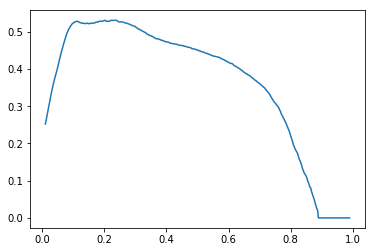

In [35]:
# Train the model
dtrain = xgb.DMatrix(x_train, label=y_train)
params['seed'] = 28537894
clf = xgb.train(params, dtrain, num_boost_round=60,
               feval=mcc_eval, evals=[(dtrain, 'train')])

y_train_pred = clf.predict(dtrain)

# Find best threshold 
thresholds = np.linspace(0.01, 0.99, 400)
mcc = np.array([matthews_corrcoef(y_train, y_train_pred>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]

print('Optimal MCC = {:.3f}'.format(mcc.max()))
print('Optimal threshold = {:.3f}'.format(best_threshold))

### Predict on test data

In [36]:
dtest = xgb.DMatrix(x_test)
y_test_pred = clf.predict(dtest)
y_test_pred_int = (y_test_pred>best_threshold).astype(int)

sub = pd.read_csv("../../data/sample_submission.csv.zip", index_col=0)
sub["Response"] = y_test_pred_int
sub.to_csv("15-benchmark_7_submission_1.csv.gz", compression="gzip")

Only With MeanTimeDiff Features:
- LB: `n_estimators=60`: Private MCC = 0.44401, public MCC = 0.43569
- CV: `n_estimators=80`: Score mean = 0.448, std = 0.013
- CV: `n_estimators=60`: Score mean = 0.445491, std = 0.0133, MCC~[0.43218, 0.45880]

Time series features, excluding MeanTimeDiff:
- LB: `n_estimators=60`: Private MCC = 0.46212, public MCC = 0.44761
- CV: `n_estimators=80`: Score mean = 0.454509, std = 0.00586
- CV: `n_estimators=60`: Score mean = 0.4534794, std = 0.0067, MCC~[0.44682, 0.46014]

In [37]:
cv_test_mean[60]+cv_test_std[60]

0.4601415478282693

In [38]:
cv_test_mean[60]-cv_test_std[60]

0.44681725217173063

In [45]:
cv_test_mean[79]

0.4545095333333334